In [2]:
import random
import numpy as np
import sys
import pandas as pd
from random import sample
from numpy import linalg as LA
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

In [12]:
# df = pd.read_csv('mnist.csv')
CSVData = open("mnist.csv")
# data is already normalized as number are betwen 0 and 1
data = np.loadtxt(CSVData, delimiter=",")
# filter out first column, label column
data = np.delete(data, 0, axis=1)
samples, dimensions = data.shape
print(samples, dimensions)
# remove the first row as we don't want to include the label row!

6000 784


### Question 1
Perform PCA on the dataset to reduce each sample into a 10-dimensional feature vector. Show the covariance matrix of the transformed data


In [31]:
def pca(data):
    k = 10
    centralized_data = data - np.mean(data , axis = 0)
    cov_mat = np.cov(centralized_data , rowvar = False)
    # for symmetric arrays
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    # sort eigen values
    top_k_eigenvalue_indexes = np.argsort(eigen_values)[::-1][:k]
    sorted_eigenvalue = eigen_values[top_k_eigenvalue_indexes]
    # find the top k eigen values
    sorted_eigenvectors = eigen_vectors[:,top_k_eigenvalue_indexes]
    p = sorted_eigenvectors[:,0:k]

    reduced_data = (p.T @ centralized_data.T).T
    return reduced_data

reduced_data = pca(data)
reduced_data_cov = np.cov(reduced_data , rowvar = False)
print("covaraince matrix sum:", np.sum(reduced_data_cov))
print("covaraince matrix")
print(reduced_data_cov)

covaraince matrix sum: 26.220565161722813
covaraince matrix
[[ 5.30558677e+00  6.03025622e-16  4.26396708e-16 -2.17106990e-15
   9.85450169e-16  2.91134196e-15 -1.50053147e-15  9.90187910e-16
   8.50424545e-16 -3.00846566e-16]
 [ 6.03025622e-16  3.87701635e+00  1.26112748e-15  7.20136662e-16
  -4.28765578e-16  5.95770955e-16 -5.52242958e-16 -1.16074659e-16
  -2.55838025e-16  2.36887060e-18]
 [ 4.26396708e-16  1.26112748e-15  3.28704664e+00 -2.36887060e-16
   1.51607718e-16 -5.44840237e-16  7.31981015e-16  6.11168614e-16
   6.46701673e-16 -8.29104709e-17]
 [-2.17106990e-15  7.20136662e-16 -2.36887060e-16  2.91254096e+00
  -1.57293008e-15  6.86972473e-16 -6.51439414e-16 -5.40102496e-16
  -2.60575766e-17 -1.42132236e-16]
 [ 9.85450169e-16 -4.28765578e-16  1.51607718e-16 -1.57293008e-15
   2.48633206e+00  6.37226191e-16  3.93380574e-16 -7.63368550e-16
  -3.87939574e-16 -1.89509648e-16]
 [ 2.91134196e-15  5.95770955e-16 -5.44840237e-16  6.86972473e-16
   6.37226191e-16  2.35358942e+00 -1.88

### question 2
Perform k-means clustering to cluster the dataset (without applying PCA) into 10 groups


In [14]:
def k_means(x, k = 10, max_iter = 50, threshold = 1e-3):
        losses = []
        prev_loss = 0
        n = x.shape[0]
        size = n // k
        centroids = {}
        # randomly assigning clusters
        np.random.shuffle(x)
        for i in range(k):
            start = i * size
            end = (i + 1) * size
            centroids[i] = x[start:end,:]

        for it in range(max_iter):
            clusters = {}
            for i in range(k):
                clusters[i] = []

            loss_sum = 0
            for feature in x:
                distances = [np.linalg.norm(feature - centroids[i]) for i in centroids]
                loss_sum += np.sum(np.array(distances)**2)
                cluster_index = distances.index(min(distances))
                clusters[cluster_index].append(feature)
            
            # print(it, loss_sum)
            losses.append(loss_sum)
            prev_centroids = dict(centroids)

            for cluster_index in clusters:
                centroids[cluster_index] = np.average(clusters[cluster_index],axis=0)

            if abs(loss_sum - prev_loss) < threshold:
                print(f"converge after {it} iterations")
                break
            prev_loss = loss_sum

        return clusters, losses
        
clusters, losses = k_means(data)

### Question 3
Please plot the loss curve, that is, the change of loss value of the k-means algorithm with respect to the number of iterations. Store loss as we compute k-means in original function.

From the plot graph seems to converge around 10-12 iterations

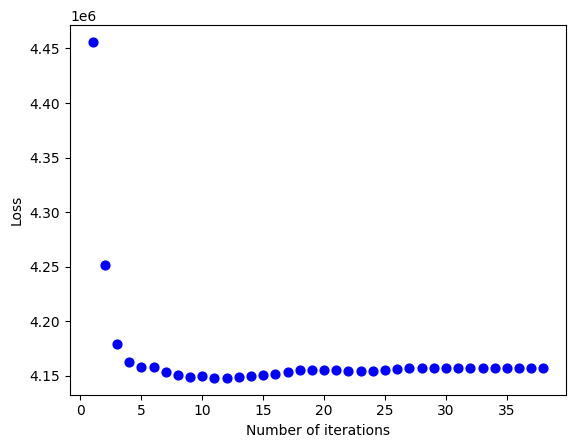

In [34]:
losses = losses[1:]
x, y = range(1, len(losses) + 1), losses
plt.scatter(x, y, c ="blue", s = 40)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

### Question 4
Please use the first 4000 samples as the training set and remaining 2000 samples as the validation set, and design a way to choose the best k in k-means algorithm. Please copy your code snippet here. Get cluster means from training set. Validation set is used to compute loss

**Training set:** A set of examples used for learning, that is to fit the parameters of the classifier.

**Validation set:** A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.

In [16]:
training_set = data[:4000]
validation_set = data[4000:]

def compute_loss(cluster_dictionary):
    loss_sum = 0
    # find the sum of loss for all clusters
    for cluster in cluster_dictionary.values():
        centroid = np.vstack(np.array(cluster).mean(axis = 0))
        loss_sum += np.sum(cdist(cluster, centroid.T, 'euclidean')**2)
    return loss_sum


In [36]:

clusters, losses = k_means(training_set, 5)

loss_array = []
k_values = []
for k in range(2, 25, 2):
    try:
        clusters, losses = k_means(training_set, k)
        loss = compute_loss(clusters)
    except Exception as e:
        print(e)
        continue
    loss_array.append(loss)
    k_values.append(k)
    print(f"k = {k} has loss {loss}")

running k-means
converge after 29 iterations
running k-means
converge after 15 iterations
k = 2 has loss 199810.30111275252
running k-means
converge after 25 iterations
k = 3 has loss 187568.10876812905
running k-means
converge after 31 iterations
k = 4 has loss 180449.1184867872
running k-means
converge after 18 iterations
k = 5 has loss 172697.2225467443
running k-means
converge after 24 iterations
k = 6 has loss 167278.2237958994
running k-means
converge after 45 iterations
k = 7 has loss 164392.1186429655
running k-means
converge after 26 iterations
k = 8 has loss 161408.9430485466
running k-means
converge after 24 iterations
k = 9 has loss 159041.5234506207
running k-means
converge after 39 iterations
k = 10 has loss 154231.7870358422
running k-means
converge after 38 iterations
k = 11 has loss 152344.8340406415
running k-means
converge after 18 iterations
k = 12 has loss 152243.4982199059
running k-means
converge after 43 iterations
k = 13 has loss 149332.67075571304
running k-me

/Users/hughsignoriello/miniconda3/envs/ML/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/hughsignoriello/miniconda3/envs/ML/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/wm/mtpy9b51653gklgmxcdb324w0000gn/T/ipykernel_87305/979411555.py:8: RuntimeWarning: Mean of empty slice.
  centroid = np.vstack(np.array(cluster).mean(axis = 0))


dispatcher for __array_function__ did not return an iterable
running k-means
converge after 27 iterations
k = 17 has loss 141663.2100256038
running k-means
converge after 29 iterations
k = 18 has loss 140001.521495443
running k-means
converge after 49 iterations
k = 19 has loss 138222.82477021098


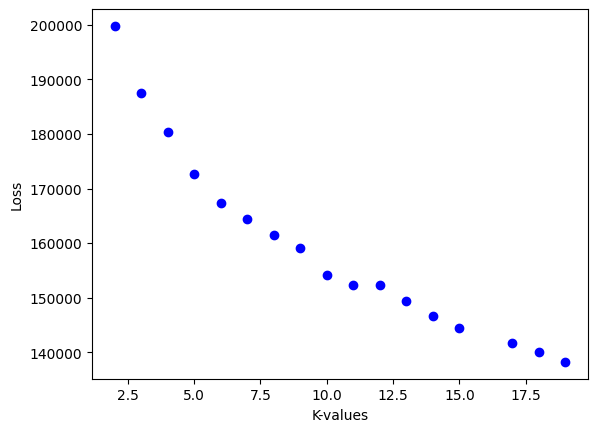

In [37]:
x, y = k_values, loss_array
plt.scatter(x, y, c ="blue")
plt.xlabel("K-values")
plt.ylabel("Loss")
plt.show()

From elbow curve optimal value for k = 7


To choose a point where diminishing returns are no longer worth the additional cost. In clustering, this means one should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data

Increasing the number of clusters will imporove fit as more as we have more clusters used, but that at some point this is over-fitting and the elbow curve reflects this. We want a balance between over and underfitting


In [17]:
# tuning paramaters with validation set
optimal_k = 12
loss_array = []
k_values = []
for k in range(optimal_k - 4, optimal_k + 4):
    try:
        clusters, losses = k_means(validation_set, k)
        loss = compute_loss(clusters)
    except Exception as e:
        print(e)
        continue
    loss_array.append(loss)
    k_values.append(k)
    print(f"k = {k} has loss {loss}")

k = 8 has loss 79781.75152600576
converge after 19 iterations
k = 9 has loss 78816.74564742799
converge after 43 iterations
k = 10 has loss 77059.56933256652
converge after 33 iterations
k = 11 has loss 75388.10606433451
k = 12 has loss 74467.2312548364
converge after 25 iterations
k = 13 has loss 74192.09882044411
converge after 43 iterations
k = 14 has loss 73481.60856974905
converge after 31 iterations
k = 15 has loss 72626.44135507601


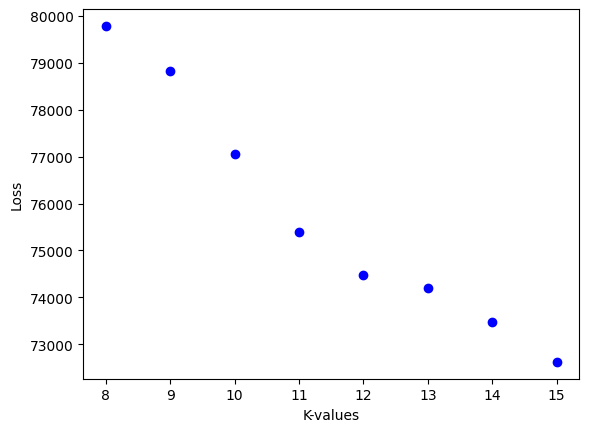

In [18]:
x, y = k_values, loss_array
plt.scatter(x, y, c ="blue")
plt.xlabel("K-values")
plt.ylabel("Loss")
plt.show()

### Evaluation
From elbow curve k = 11 gives the most optimal value of clusters

As lower loss value does not necessary indicate better clustering as when we add more clusters, naturally they will be closer to the centroid on average even if they are incorrectly clustered so it is expected that the mean value of loss will decrease as we add more clusters.

On the other hand too few clusters will result in values being further away from the centroid.

We want to minimize our loss without incorrectly clustering 

### Question 5
Implement kernel k-means algorithm with RBF-kernel

Use the first 500 samples and cluster the them into 5 groups. This is for reducing the running time of your code. 


In [20]:
def getHyperParameter(X):
    n = X.shape[0] # 500
    hyperparameter = 0
    for i in range(n):
        for j in range(n):
            hyperparameter += np.linalg.norm(X[i]-X[j])**2
    hyperparameter /= n**2
    return hyperparameter

def rbfKernel(X):
    n = X.shape[0] 
    hyperparameter = getHyperParameter(X)
    K=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = np.exp(-np.linalg.norm(X[i]-X[j])**2) / hyperparameter
    return K

def calculateDistances(Kernel, cluster_indexes, k = 10):
    res = []
    for cluster_num in range(k):
        kernel_indexes = np.flatnonzero((cluster_num == cluster_indexes))
        K = Kernel[kernel_indexes][:,kernel_indexes]
        # print(K.shape)
        n = K.shape[0]
        distances = np.zeros((n,10))
        k = 10
        if n < 10:
            k = n
            distances.fill(sys.maxsize)
        for j in range(k):
            for i in range(n):
                distances[i, j] = K[i, j] - 2 * sum(K[:,j]) / n + np.sum(K) / (n**2)
        res.append(distances)

    return np.array(res)

def compute_loss(distances):
    losses = 0
    for row in distances:
        for i in row:
            if i == sys.maxsize: continue
            losses += i**2
    return losses

def kernelKmean(X, iteration_limit = 30, threshold = 1e-4, k = 10):
    K = rbfKernel(X)
    n = K.shape[0]
    losses = []
    cluster_indexes = np.array([random.randint(0, k - 1) for _ in range(n)])
    prev_loss = 0
    # precomputing kernel
    K = rbfKernel(X) 
    print("running k means")
    for it in range(iteration_limit):
        loss_sum = 0
        distances = calculateDistances(K, cluster_indexes)
        distances = np.vstack(np.array(distances))
    
        loss_sum = compute_loss(distances)
        losses.append(loss_sum)

        cluster_indexes = np.array([np.argmin(i) for i in distances])
        print(it, loss_sum)
        if prev_loss == loss_sum:
            print(f"convergence achieved after {it} iterations")
            break
        prev_loss = loss_sum
       
    return cluster_indexes, losses

kernel_data = data[:500]
clusters, losses = kernelKmean(kernel_data)

running k means
0 0.008746832857891754
1 0.005108910734723423


/var/folders/wj/zt45pqy17xs66npk88v4sklc0000gn/T/ipykernel_82379/544858985.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(res)


2 0.0048700161197777455
3 0.004257520641580184
4 0.0020461770176332474
5 0.0022247026128229164
6 0.0024032298306997835
7 0.0025817258821659353
8 0.0029387750814509257
9 0.003584168557496292
10 0.002992123024626397
11 0.0036169358825400236
12 0.0034461044086599494
13 0.004005261018169181
14 0.003186944316188509
15 0.0040795527509890584
16 0.0033697767090074744
17 0.0038164970597440264
18 0.002581559282518524
19 0.0027855444617484785
20 0.0033104632810908425
21 0.0030699943777356582
22 0.002899552780006792
23 0.0022835983588205874
24 0.002110986164444165
25 0.0020244053277699136
26 0.0021152207617316163
27 0.0020279481755180622
28 0.0019398364369838281
29 0.002029661351811835


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 

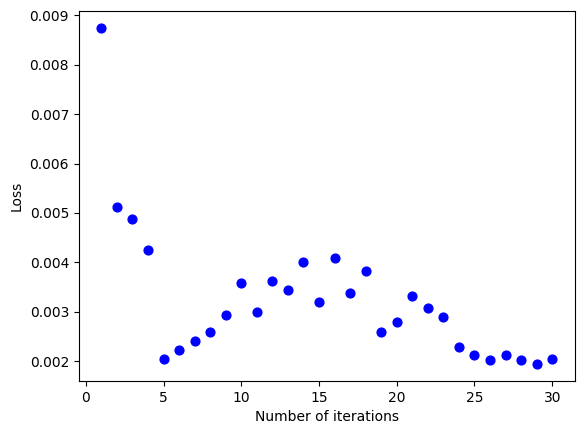

In [21]:
print(clusters, losses)
print("k-means clustering loss iteration relationship")
x, y = range(1, len(losses) + 1), losses
plt.scatter(x, y, c ="blue", s = 40)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()